In [3]:
#default_exp pretrain

# Pretrain the Barlow Twins model

In [4]:
#exporti
from fastcore.script import *
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.barlow_twins import *

try:
    import wandb
    from fastai.callback.wandb import *
except:
    wandb = False

# fixup depreciation
from kornia import augmentation as korniatfm
korniatfm.GaussianBlur = korniatfm.RandomGaussianBlur

In [5]:
#export
def get_dataloaders(path, size=224):
    fnames = get_image_files(path)
    dls = ImageDataLoaders.from_name_func(
        path, fnames,
        lambda x: False,
        item_tfms=RandomResizedCrop(size),
        valid_pct=0)

    return dls, dls.test_dl(fnames)

In [6]:
dls, test_dls = get_dataloaders('../yolov5/')

In [4]:
#export
def train_model(dls, samples=50000, size=224, backbone='resnet18', lr=5e-4, pretrained=True, preserve_colors=True):
    projection_size = 2048
    epochs = math.ceil(samples / len(dls.items))

    fastai_encoder = create_encoder(backbone, pretrained=pretrained)
    model = create_barlow_twins_model(fastai_encoder, projection_size=projection_size, hidden_size=projection_size)

    aug_pipelines = get_barlow_twins_aug_pipelines(size=size, bw=not preserve_colors, jitter=not preserve_colors)

    cbs = [BarlowTwins(aug_pipelines)]
    if wandb:
        cbs += [WandbCallback()]
    
    learn = Learner(dls, model, cbs=cbs)
    learn.fit_one_cycle(epochs, lr)
    
    return learn

In [9]:
wandb = False
learn = train_model(dls)

epoch,train_loss,valid_loss,time
0,747.185425,None,00:25
1,559.766846,None,00:24
2,499.561951,None,00:24
3,468.551025,None,00:24
4,443.763916,None,00:24
5,427.564056,None,00:24


/opt/miniconda3/lib/python3.9/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [5]:
#export
def push_vector(stack, vec):
    stack.append(vec)
    while len(stack) > 1 and len(stack[-1]) > len(stack[-2]):
        stack = stack[:-3] + torch.cat(stack[-2:])

def extract_features(test_dl, model):
    features = []
    with torch.no_grad():
        for (dx,) in progress_bar(test_dl):
            push_vector(features, model.encoder[:-3](dx).detach().cpu())
    raw_features = torch.cat(features).permute(0,2,3,1)
    print(raw_features.shape)
    return raw_features / torch.linalg.vector_norm(raw_features, dim=-1, keepdims=True)

In [13]:
features = extract_features(test_dls, learn.model)

In [14]:
#export
from sklearn.cluster import MiniBatchKMeans

def calculate_bovw(features, n_vwords=1024):
    print("Calculating KMeans:")
    kmeans = MiniBatchKMeans(n_clusters=n_vwords, verbose=1).fit(features.reshape(-1,256).cpu().numpy())
    vwords = kmeans.labels_.reshape(features.shape[:3])

    print("Calculating BoVW features:")
    bovw = np.zeros((len(features), n_vwords), dtype=np.uint8)
    for i in range(len(features)):
        bovw[i, np.unique(vwords[i])] = 1
    print(f"done ({bovw.shape})")
    return vwords, bovw

In [17]:
vwords, bovw = calculate_bovw(features)

Calculating KMeans:
Init 1/3 with method k-means++
Inertia for init 1/3: 396.73809814453125
Init 2/3 with method k-means++
Inertia for init 2/3: 393.5136413574219
Init 3/3 with method k-means++
Inertia for init 3/3: 397.2372131347656
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 1/173950: mean batch inertia: 0.13172702491283417
[MiniBatchKMeans] Reassigning 404 cluster centers.
Minibatch step 2/173950: mean batch inertia: 0.1267213523387909, ewa inertia: 0.1267213523387909
Minibatch step 3/173950: mean batch inertia: 0.11721967905759811, ewa inertia: 0.12671042774212873
Minibatch step 4/173950: mean batch inertia: 0.1121915727853775, ewa inertia: 0.12669373461559144
Minibatch step 5/173950: mean batch inertia: 0.11015262454748154, ewa inertia: 0.126674716391065
Minibatch step 6/173950: mean batch inertia: 0.09894461184740067, ewa inertia: 0.1266428335638435
Minibatch step 7/173950: mean batch inertia: 0.10339026153087616, ewa inertia: 0.12661609880215466
Minibatch s

Minibatch step 102/173950: mean batch inertia: 0.08603529632091522, ewa inertia: 0.12308420876232709
Minibatch step 103/173950: mean batch inertia: 0.08926117420196533, ewa inertia: 0.1230453205581627
Minibatch step 104/173950: mean batch inertia: 0.09203396737575531, ewa inertia: 0.12300966509880941
Minibatch step 105/173950: mean batch inertia: 0.08683952689170837, ewa inertia: 0.12296807830041787
Minibatch step 106/173950: mean batch inertia: 0.0899512991309166, ewa inertia: 0.12293011709244574
Minibatch step 107/173950: mean batch inertia: 0.08971748501062393, ewa inertia: 0.12289193070160224
Minibatch step 108/173950: mean batch inertia: 0.08906897902488708, ewa inertia: 0.12285304259273375
Minibatch step 109/173950: mean batch inertia: 0.08583422750234604, ewa inertia: 0.12281048002382558
Minibatch step 110/173950: mean batch inertia: 0.09308704733848572, ewa inertia: 0.1227763053575439
Minibatch step 111/173950: mean batch inertia: 0.09275579452514648, ewa inertia: 0.12274178912

Minibatch step 183/173950: mean batch inertia: 0.08817487955093384, ewa inertia: 0.12002031945094756
Minibatch step 184/173950: mean batch inertia: 0.08899057656526566, ewa inertia: 0.11998464284794041
Minibatch step 185/173950: mean batch inertia: 0.08522927761077881, ewa inertia: 0.1199446826918894
Minibatch step 186/173950: mean batch inertia: 0.08741595596075058, ewa inertia: 0.1199072826246639
Minibatch step 187/173950: mean batch inertia: 0.08441771566867828, ewa inertia: 0.11986647831649258
Minibatch step 188/173950: mean batch inertia: 0.09248621016740799, ewa inertia: 0.11983499771542595
Minibatch step 189/173950: mean batch inertia: 0.08835925161838531, ewa inertia: 0.11979880831798251
Minibatch step 190/173950: mean batch inertia: 0.09235141426324844, ewa inertia: 0.11976725053856813
Minibatch step 191/173950: mean batch inertia: 0.08764851838350296, ewa inertia: 0.11973032186466932
Minibatch step 192/173950: mean batch inertia: 0.08709345757961273, ewa inertia: 0.1196927974

Minibatch step 279/173950: mean batch inertia: 0.08895998448133469, ewa inertia: 0.11661783436943056
Minibatch step 280/173950: mean batch inertia: 0.08916342258453369, ewa inertia: 0.1165862685213456
Minibatch step 281/173950: mean batch inertia: 0.08731110394001007, ewa inertia: 0.11655260925357193
Minibatch step 282/173950: mean batch inertia: 0.08554406464099884, ewa inertia: 0.11651695702338595
Minibatch step 283/173950: mean batch inertia: 0.08423242717981339, ewa inertia: 0.11647983772276058
Minibatch step 284/173950: mean batch inertia: 0.09151974320411682, ewa inertia: 0.11645113972850252
Minibatch step 285/173950: mean batch inertia: 0.08456282317638397, ewa inertia: 0.11641447597610252
Minibatch step 286/173950: mean batch inertia: 0.08958309143781662, ewa inertia: 0.11638362645672909
Minibatch step 287/173950: mean batch inertia: 0.08842721581459045, ewa inertia: 0.11635148343293224
Minibatch step 288/173950: mean batch inertia: 0.08444662392139435, ewa inertia: 0.116314800

Minibatch step 377/173950: mean batch inertia: 0.08724791556596756, ewa inertia: 0.11347445265402875
Minibatch step 378/173950: mean batch inertia: 0.08635452389717102, ewa inertia: 0.11344327137948822
Minibatch step 379/173950: mean batch inertia: 0.08941177278757095, ewa inertia: 0.11341564104306907
Minibatch step 380/173950: mean batch inertia: 0.08747605234384537, ewa inertia: 0.11338581687044862
Minibatch step 381/173950: mean batch inertia: 0.0867852121591568, ewa inertia: 0.11335523269134241
Minibatch step 382/173950: mean batch inertia: 0.08651021122932434, ewa inertia: 0.1133243674928473
Minibatch step 383/173950: mean batch inertia: 0.09160737693309784, ewa inertia: 0.11329939827368346
Minibatch step 384/173950: mean batch inertia: 0.0862349197268486, ewa inertia: 0.11326828075330089
Minibatch step 385/173950: mean batch inertia: 0.08751913905143738, ewa inertia: 0.11323867554807387
Minibatch step 386/173950: mean batch inertia: 0.0859706848859787, ewa inertia: 0.113207324038

Minibatch step 459/173950: mean batch inertia: 0.09036251902580261, ewa inertia: 0.11109016342311044
Minibatch step 460/173950: mean batch inertia: 0.08583632856607437, ewa inertia: 0.11106112769942038
Minibatch step 461/173950: mean batch inertia: 0.08563672006130219, ewa inertia: 0.11103189585881702
Minibatch step 462/173950: mean batch inertia: 0.08785751461982727, ewa inertia: 0.11100525099738695
Minibatch step 463/173950: mean batch inertia: 0.08569366484880447, ewa inertia: 0.11097614887385884
Minibatch step 464/173950: mean batch inertia: 0.08776764571666718, ewa inertia: 0.11094946478058164
Minibatch step 465/173950: mean batch inertia: 0.08533316105604172, ewa inertia: 0.11092001230648742
Minibatch step 466/173950: mean batch inertia: 0.08565486967563629, ewa inertia: 0.1108909635816275
Minibatch step 467/173950: mean batch inertia: 0.08576387912034988, ewa inertia: 0.1108620735898427
Minibatch step 468/173950: mean batch inertia: 0.0846799910068512, ewa inertia: 0.11083197060

Minibatch step 546/173950: mean batch inertia: 0.08352550864219666, ewa inertia: 0.10877561895257645
Minibatch step 547/173950: mean batch inertia: 0.08706562221050262, ewa inertia: 0.10875065777458967
Minibatch step 548/173950: mean batch inertia: 0.08467613160610199, ewa inertia: 0.10872297796699788
Minibatch step 549/173950: mean batch inertia: 0.08370523154735565, ewa inertia: 0.10869421368717656
Minibatch step 550/173950: mean batch inertia: 0.08971287310123444, ewa inertia: 0.10867238979533438
Minibatch step 551/173950: mean batch inertia: 0.08823833614587784, ewa inertia: 0.10864889563933816
Minibatch step 552/173950: mean batch inertia: 0.0904763862490654, ewa inertia: 0.10862800170523278
Minibatch step 553/173950: mean batch inertia: 0.08596888929605484, ewa inertia: 0.10860194927673233
Minibatch step 554/173950: mean batch inertia: 0.08865649253129959, ewa inertia: 0.10857901688748486
Minibatch step 555/173950: mean batch inertia: 0.08527185767889023, ewa inertia: 0.108552219

Minibatch step 630/173950: mean batch inertia: 0.09147157520055771, ewa inertia: 0.1067284537298453
Minibatch step 631/173950: mean batch inertia: 0.08761336654424667, ewa inertia: 0.1067064760621772
Minibatch step 632/173950: mean batch inertia: 0.0854804590344429, ewa inertia: 0.1066820713423021
Minibatch step 633/173950: mean batch inertia: 0.08705998957157135, ewa inertia: 0.10665951075505886
Minibatch step 634/173950: mean batch inertia: 0.08858321607112885, ewa inertia: 0.1066387274442962
Minibatch step 635/173950: mean batch inertia: 0.08622345328330994, ewa inertia: 0.10661525488011134
Minibatch step 636/173950: mean batch inertia: 0.09076766669750214, ewa inertia: 0.10659703403586217
Minibatch step 637/173950: mean batch inertia: 0.08930637687444687, ewa inertia: 0.1065771540157939
Minibatch step 638/173950: mean batch inertia: 0.08711636811494827, ewa inertia: 0.10655477887928859
Minibatch step 639/173950: mean batch inertia: 0.08826247602701187, ewa inertia: 0.10653374721204

Minibatch step 718/173950: mean batch inertia: 0.08635646849870682, ewa inertia: 0.10480221485484806
Minibatch step 719/173950: mean batch inertia: 0.0915512889623642, ewa inertia: 0.10478697953613192
Minibatch step 720/173950: mean batch inertia: 0.0865560844540596, ewa inertia: 0.10476601847278362
Minibatch step 721/173950: mean batch inertia: 0.08554109930992126, ewa inertia: 0.10474391452524706
Minibatch step 722/173950: mean batch inertia: 0.08328795433044434, ewa inertia: 0.10471924542705868
Minibatch step 723/173950: mean batch inertia: 0.09005679190158844, ewa inertia: 0.1047023871973445
Minibatch step 724/173950: mean batch inertia: 0.08641568571329117, ewa inertia: 0.10468136197030474
Minibatch step 725/173950: mean batch inertia: 0.09274492412805557, ewa inertia: 0.10466763799083811
Minibatch step 726/173950: mean batch inertia: 0.09070509672164917, ewa inertia: 0.10465158448876215
Minibatch step 727/173950: mean batch inertia: 0.086685910820961, ewa inertia: 0.1046309283650

Minibatch step 802/173950: mean batch inertia: 0.08835731446743011, ewa inertia: 0.10310663726596576
Minibatch step 803/173950: mean batch inertia: 0.08679571002721786, ewa inertia: 0.10308788369530554
Minibatch step 804/173950: mean batch inertia: 0.0854368656873703, ewa inertia: 0.10306758934854085
Minibatch step 805/173950: mean batch inertia: 0.08887096494436264, ewa inertia: 0.10305126670820265
Minibatch step 806/173950: mean batch inertia: 0.08705320209264755, ewa inertia: 0.10303287285291758
Minibatch step 807/173950: mean batch inertia: 0.08421657979488373, ewa inertia: 0.10301123872530102
Minibatch step 808/173950: mean batch inertia: 0.0878048837184906, ewa inertia: 0.10299375514212206
Minibatch step 809/173950: mean batch inertia: 0.08568225800991058, ewa inertia: 0.10297385116119251
Minibatch step 810/173950: mean batch inertia: 0.08547518402338028, ewa inertia: 0.1029537319806073
Minibatch step 811/173950: mean batch inertia: 0.08606870472431183, ewa inertia: 0.10293431833

Minibatch step 884/173950: mean batch inertia: 0.0856209546327591, ewa inertia: 0.10160403111074295
Minibatch step 885/173950: mean batch inertia: 0.08457472175359726, ewa inertia: 0.1015844515766276
Minibatch step 886/173950: mean batch inertia: 0.09113194793462753, ewa inertia: 0.10157243375797405
Minibatch step 887/173950: mean batch inertia: 0.08528637886047363, ewa inertia: 0.10155370878441332
Minibatch step 888/173950: mean batch inertia: 0.07978898286819458, ewa inertia: 0.1015286846812832
Minibatch step 889/173950: mean batch inertia: 0.09025197476148605, ewa inertia: 0.10151571922731481
Minibatch step 890/173950: mean batch inertia: 0.08856915682554245, ewa inertia: 0.10150083385205351
Minibatch step 891/173950: mean batch inertia: 0.08492667973041534, ewa inertia: 0.10148177763496027
Minibatch step 892/173950: mean batch inertia: 0.09006639569997787, ewa inertia: 0.1014686527421447
Minibatch step 893/173950: mean batch inertia: 0.08820974081754684, ewa inertia: 0.101453408241

Minibatch step 978/173950: mean batch inertia: 0.08523251116275787, ewa inertia: 0.1000534799213061
Minibatch step 979/173950: mean batch inertia: 0.08932222425937653, ewa inertia: 0.10004114160611512
Minibatch step 980/173950: mean batch inertia: 0.08646442741155624, ewa inertia: 0.10002553171065948
Minibatch step 981/173950: mean batch inertia: 0.08782100677490234, ewa inertia: 0.10001149949670825
Minibatch step 982/173950: mean batch inertia: 0.08407635241746902, ewa inertia: 0.09999317798117713
Minibatch step 983/173950: mean batch inertia: 0.0848955512046814, ewa inertia: 0.09997581940882803
Minibatch step 984/173950: mean batch inertia: 0.08518698066473007, ewa inertia: 0.09995881586707282
Minibatch step 985/173950: mean batch inertia: 0.08654294908046722, ewa inertia: 0.09994339090673378
Minibatch step 986/173950: mean batch inertia: 0.08345591276884079, ewa inertia: 0.09992443434578896
Minibatch step 987/173950: mean batch inertia: 0.08480441570281982, ewa inertia: 0.0999070500

Minibatch step 1067/173950: mean batch inertia: 0.08495386689901352, ewa inertia: 0.098650755762342
Minibatch step 1068/173950: mean batch inertia: 0.08006543666124344, ewa inertia: 0.09862938719819457
Minibatch step 1069/173950: mean batch inertia: 0.0863218680024147, ewa inertia: 0.09861523656607465
Minibatch step 1070/173950: mean batch inertia: 0.0855569839477539, ewa inertia: 0.09860022277442491
Minibatch step 1071/173950: mean batch inertia: 0.0862264633178711, ewa inertia: 0.0985859959822319
Minibatch step 1072/173950: mean batch inertia: 0.08473241329193115, ewa inertia: 0.09857006775583024
Minibatch step 1073/173950: mean batch inertia: 0.0900370180606842, ewa inertia: 0.09856025683900971
Minibatch step 1074/173950: mean batch inertia: 0.08797580003738403, ewa inertia: 0.09854808730654696
Minibatch step 1075/173950: mean batch inertia: 0.08483148366212845, ewa inertia: 0.0985323165724925
Minibatch step 1076/173950: mean batch inertia: 0.09139297157526016, ewa inertia: 0.098524

Minibatch step 1157/173950: mean batch inertia: 0.08412500470876694, ewa inertia: 0.09744704613175537
Minibatch step 1158/173950: mean batch inertia: 0.08710557222366333, ewa inertia: 0.09743515597009701
Minibatch step 1159/173950: mean batch inertia: 0.08901888132095337, ewa inertia: 0.09742547931597317
Minibatch step 1160/173950: mean batch inertia: 0.08537717163562775, ewa inertia: 0.09741162671359735
Minibatch step 1161/173950: mean batch inertia: 0.08541084080934525, ewa inertia: 0.09739782874962269
Minibatch step 1162/173950: mean batch inertia: 0.08648397773504257, ewa inertia: 0.09738528049450627
Minibatch step 1163/173950: mean batch inertia: 0.08633482456207275, ewa inertia: 0.09737257517719823
Minibatch step 1164/173950: mean batch inertia: 0.08571189641952515, ewa inertia: 0.09735916825312657
Minibatch step 1165/173950: mean batch inertia: 0.08371363580226898, ewa inertia: 0.09734347923353451
Minibatch step 1166/173950: mean batch inertia: 0.0868733823299408, ewa inertia: 0

Minibatch step 1249/173950: mean batch inertia: 0.08504292368888855, ewa inertia: 0.09636046835916551
Minibatch step 1250/173950: mean batch inertia: 0.08491361141204834, ewa inertia: 0.09634730727779638
Minibatch step 1251/173950: mean batch inertia: 0.08358963578939438, ewa inertia: 0.0963326390808131
Minibatch step 1252/173950: mean batch inertia: 0.08528045564889908, ewa inertia: 0.09631993177730386
Minibatch step 1253/173950: mean batch inertia: 0.08959688246250153, ewa inertia: 0.09631220191752754
Minibatch step 1254/173950: mean batch inertia: 0.08496832102537155, ewa inertia: 0.09629915923339571
Minibatch step 1255/173950: mean batch inertia: 0.08334504812955856, ewa inertia: 0.09628426517897622
Minibatch step 1256/173950: mean batch inertia: 0.08435599505901337, ewa inertia: 0.0962705505903894
Minibatch step 1257/173950: mean batch inertia: 0.08606421947479248, ewa inertia: 0.09625881580983668
Minibatch step 1258/173950: mean batch inertia: 0.08591483533382416, ewa inertia: 0.

Minibatch step 1337/173950: mean batch inertia: 0.08360034227371216, ewa inertia: 0.0953875435876728
Minibatch step 1338/173950: mean batch inertia: 0.08679504692554474, ewa inertia: 0.09537766432140288
Minibatch step 1339/173950: mean batch inertia: 0.087798573076725, ewa inertia: 0.09536895022311055
Minibatch step 1340/173950: mean batch inertia: 0.08542680740356445, ewa inertia: 0.09535751919438047
Minibatch step 1341/173950: mean batch inertia: 0.08604324609041214, ewa inertia: 0.09534681006201497
Minibatch step 1342/173950: mean batch inertia: 0.08630748838186264, ewa inertia: 0.0953364170564324
Minibatch step 1343/173950: mean batch inertia: 0.08859744668006897, ewa inertia: 0.09532866889133543
Minibatch step 1344/173950: mean batch inertia: 0.08733740448951721, ewa inertia: 0.09531948089488186
Minibatch step 1345/173950: mean batch inertia: 0.08804664015769958, ewa inertia: 0.09531111890965141
Minibatch step 1346/173950: mean batch inertia: 0.08316586166620255, ewa inertia: 0.09

Minibatch step 1420/173950: mean batch inertia: 0.0879637748003006, ewa inertia: 0.09455379440915468
Minibatch step 1421/173950: mean batch inertia: 0.08504600822925568, ewa inertia: 0.09454286278415647
Minibatch step 1422/173950: mean batch inertia: 0.08422902226448059, ewa inertia: 0.09453100439412548
Minibatch step 1423/173950: mean batch inertia: 0.08870286494493484, ewa inertia: 0.09452430346146982
Minibatch step 1424/173950: mean batch inertia: 0.08820773661136627, ewa inertia: 0.09451704095695249
Minibatch step 1425/173950: mean batch inertia: 0.08519290387630463, ewa inertia: 0.09450632048343016
Minibatch step 1426/173950: mean batch inertia: 0.08193805813789368, ewa inertia: 0.09449187006056191
Minibatch step 1427/173950: mean batch inertia: 0.08682670444250107, ewa inertia: 0.0944830569978257
Minibatch step 1428/173950: mean batch inertia: 0.08765296638011932, ewa inertia: 0.0944752040667728
Minibatch step 1429/173950: mean batch inertia: 0.08389442414045334, ewa inertia: 0.0

Minibatch step 1527/173950: mean batch inertia: 0.08708172291517258, ewa inertia: 0.09357765228794045
Minibatch step 1528/173950: mean batch inertia: 0.08746317028999329, ewa inertia: 0.09357062213149865
Minibatch step 1529/173950: mean batch inertia: 0.08591915667057037, ewa inertia: 0.09356182482058704
Minibatch step 1530/173950: mean batch inertia: 0.0856320932507515, ewa inertia: 0.09355270757181663
Minibatch step 1531/173950: mean batch inertia: 0.08425049483776093, ewa inertia: 0.0935420123059221
Minibatch step 1532/173950: mean batch inertia: 0.08614939451217651, ewa inertia: 0.0935335126064182
Minibatch step 1533/173950: mean batch inertia: 0.08458063751459122, ewa inertia: 0.09352321899323551
Minibatch step 1534/173950: mean batch inertia: 0.09356340765953064, ewa inertia: 0.09352326520035678
Minibatch step 1535/173950: mean batch inertia: 0.08712293207645416, ewa inertia: 0.09351590638514468
Minibatch step 1536/173950: mean batch inertia: 0.08761333674192429, ewa inertia: 0.0

Minibatch step 1618/173950: mean batch inertia: 0.0849233940243721, ewa inertia: 0.09283649455550294
Minibatch step 1619/173950: mean batch inertia: 0.0843885987997055, ewa inertia: 0.09282678154485262
Minibatch step 1620/173950: mean batch inertia: 0.08097042888402939, ewa inertia: 0.09281314964372629
Minibatch step 1621/173950: mean batch inertia: 0.08602866530418396, ewa inertia: 0.09280534914872117
Minibatch step 1622/173950: mean batch inertia: 0.08509030938148499, ewa inertia: 0.09279647874293102
Minibatch step 1623/173950: mean batch inertia: 0.08673317730426788, ewa inertia: 0.09278950743159478
Minibatch step 1624/173950: mean batch inertia: 0.08241289108991623, ewa inertia: 0.0927775768647466
Minibatch step 1625/173950: mean batch inertia: 0.0848793089389801, ewa inertia: 0.09276849579145927
Minibatch step 1626/173950: mean batch inertia: 0.08822104334831238, ewa inertia: 0.09276326733513252
Minibatch step 1627/173950: mean batch inertia: 0.08564826846122742, ewa inertia: 0.09

Minibatch step 1724/173950: mean batch inertia: 0.08868596702814102, ewa inertia: 0.09201370805074334
Minibatch step 1725/173950: mean batch inertia: 0.08553680032491684, ewa inertia: 0.09200626119349739
Minibatch step 1726/173950: mean batch inertia: 0.08462782204151154, ewa inertia: 0.09199777779595822
Minibatch step 1727/173950: mean batch inertia: 0.08587894588708878, ewa inertia: 0.09199074263818445
Minibatch step 1728/173950: mean batch inertia: 0.08669223636388779, ewa inertia: 0.09198465065393645
Minibatch step 1729/173950: mean batch inertia: 0.08480797708034515, ewa inertia: 0.0919763992373862
Minibatch step 1730/173950: mean batch inertia: 0.08935002982616425, ewa inertia: 0.09197337955594122
Minibatch step 1731/173950: mean batch inertia: 0.08866099268198013, ewa inertia: 0.0919695711224668
Minibatch step 1732/173950: mean batch inertia: 0.0870661810040474, ewa inertia: 0.09196393342500703
Minibatch step 1733/173950: mean batch inertia: 0.08796373009681702, ewa inertia: 0.0

Minibatch step 1805/173950: mean batch inertia: 0.08505754917860031, ewa inertia: 0.09147343605169897
Minibatch step 1806/173950: mean batch inertia: 0.0860285833477974, ewa inertia: 0.0914671758049072
Minibatch step 1807/173950: mean batch inertia: 0.08440890908241272, ewa inertia: 0.09145906052722974
Minibatch step 1808/173950: mean batch inertia: 0.08215375989675522, ewa inertia: 0.09144836171101078
Minibatch step 1809/173950: mean batch inertia: 0.08758405596017838, ewa inertia: 0.09144391870603073
Minibatch step 1810/173950: mean batch inertia: 0.08495507389307022, ewa inertia: 0.09143645812405879
Minibatch step 1811/173950: mean batch inertia: 0.08613400161266327, ewa inertia: 0.09143036159800581
Minibatch step 1812/173950: mean batch inertia: 0.08670912683010101, ewa inertia: 0.0914249333345768
Minibatch step 1813/173950: mean batch inertia: 0.08335531502962112, ewa inertia: 0.09141565525032887
Minibatch step 1814/173950: mean batch inertia: 0.08454515039920807, ewa inertia: 0.0

Minibatch step 1892/173950: mean batch inertia: 0.08512464910745621, ewa inertia: 0.09091288782550248
Minibatch step 1893/173950: mean batch inertia: 0.08675631880760193, ewa inertia: 0.09090810878936062
Minibatch step 1894/173950: mean batch inertia: 0.08576975017786026, ewa inertia: 0.09090220093569369
Minibatch step 1895/173950: mean batch inertia: 0.08817078173160553, ewa inertia: 0.09089906047272081
Minibatch step 1896/173950: mean batch inertia: 0.08646468818187714, ewa inertia: 0.09089396203086812
Minibatch step 1897/173950: mean batch inertia: 0.08868281543254852, ewa inertia: 0.09089141975394145
Minibatch step 1898/173950: mean batch inertia: 0.08793791383504868, ewa inertia: 0.09088802394565082
Minibatch step 1899/173950: mean batch inertia: 0.08362024277448654, ewa inertia: 0.09087966777768186
Minibatch step 1900/173950: mean batch inertia: 0.08881053328514099, ewa inertia: 0.09087728877988832
Minibatch step 1901/173950: mean batch inertia: 0.08705861121416092, ewa inertia: 

Minibatch step 1984/173950: mean batch inertia: 0.08209417015314102, ewa inertia: 0.09042494865689743
Minibatch step 1985/173950: mean batch inertia: 0.08523572236299515, ewa inertia: 0.09041898231785674
Minibatch step 1986/173950: mean batch inertia: 0.09071290493011475, ewa inertia: 0.09041932025685903
Minibatch step 1987/173950: mean batch inertia: 0.08865813165903091, ewa inertia: 0.09041729532140735
Minibatch step 1988/173950: mean batch inertia: 0.08547545224428177, ewa inertia: 0.09041161341246483
Minibatch step 1989/173950: mean batch inertia: 0.08639734238386154, ewa inertia: 0.09040699798415211
Minibatch step 1990/173950: mean batch inertia: 0.08654188364744186, ewa inertia: 0.09040255404949638
Minibatch step 1991/173950: mean batch inertia: 0.08479411154985428, ewa inertia: 0.09039610571451387
Minibatch step 1992/173950: mean batch inertia: 0.08848259598016739, ewa inertia: 0.09039390564706909
Minibatch step 1993/173950: mean batch inertia: 0.08789832144975662, ewa inertia: 

Minibatch step 2074/173950: mean batch inertia: 0.0870613232254982, ewa inertia: 0.08998851749257374
Minibatch step 2075/173950: mean batch inertia: 0.08710881322622299, ewa inertia: 0.08998520653810443
Minibatch step 2076/173950: mean batch inertia: 0.08431283384561539, ewa inertia: 0.08997868469906103
Minibatch step 2077/173950: mean batch inertia: 0.0834525004029274, ewa inertia: 0.08997118118583043
Minibatch step 2078/173950: mean batch inertia: 0.08626700937747955, ewa inertia: 0.08996692229565645
Minibatch step 2079/173950: mean batch inertia: 0.08576271682977676, ewa inertia: 0.08996208848926884
Minibatch step 2080/173950: mean batch inertia: 0.08695945888757706, ewa inertia: 0.08995863620077674
Minibatch step 2081/173950: mean batch inertia: 0.08559639751911163, ewa inertia: 0.08995362069490413
Minibatch step 2082/173950: mean batch inertia: 0.08553694188594818, ewa inertia: 0.08994854259622127
Minibatch step 2083/173950: mean batch inertia: 0.08559990674257278, ewa inertia: 0.

Minibatch step 2169/173950: mean batch inertia: 0.08732021600008011, ewa inertia: 0.08958312381143446
Minibatch step 2170/173950: mean batch inertia: 0.08818820118904114, ewa inertia: 0.08958151999213089
Minibatch step 2171/173950: mean batch inertia: 0.08232321590185165, ewa inertia: 0.08957317472048336
Minibatch step 2172/173950: mean batch inertia: 0.08695214986801147, ewa inertia: 0.0895701611839717
Minibatch step 2173/173950: mean batch inertia: 0.08524781465530396, ewa inertia: 0.08956519154430273
Minibatch step 2174/173950: mean batch inertia: 0.08493407815694809, ewa inertia: 0.08955986689838445
Minibatch step 2175/173950: mean batch inertia: 0.08822387456893921, ewa inertia: 0.08955833083448171
Minibatch step 2176/173950: mean batch inertia: 0.08542921394109726, ewa inertia: 0.08955358336155814
Minibatch step 2177/173950: mean batch inertia: 0.08792463690042496, ewa inertia: 0.0895517104721685
Minibatch step 2178/173950: mean batch inertia: 0.08688024431467056, ewa inertia: 0.

Minibatch step 2266/173950: mean batch inertia: 0.08662751317024231, ewa inertia: 0.08921267975022376
Minibatch step 2267/173950: mean batch inertia: 0.08264598250389099, ewa inertia: 0.08920512965702483
Minibatch step 2268/173950: mean batch inertia: 0.08677519857883453, ewa inertia: 0.08920233583154162
Minibatch step 2269/173950: mean batch inertia: 0.08145880699157715, ewa inertia: 0.08919343267029675
Minibatch step 2270/173950: mean batch inertia: 0.0851903185248375, ewa inertia: 0.08918883006966657
Minibatch step 2271/173950: mean batch inertia: 0.08494222909212112, ewa inertia: 0.08918394751882612
Minibatch step 2272/173950: mean batch inertia: 0.0830063596367836, ewa inertia: 0.08917684480607657
Minibatch step 2273/173950: mean batch inertia: 0.08709757030010223, ewa inertia: 0.08917445414975159
Minibatch step 2274/173950: mean batch inertia: 0.08611253648996353, ewa inertia: 0.0891709336945164
Minibatch step 2275/173950: mean batch inertia: 0.0855032354593277, ewa inertia: 0.08

Minibatch step 2355/173950: mean batch inertia: 0.08875858783721924, ewa inertia: 0.08886977973684107
Minibatch step 2356/173950: mean batch inertia: 0.08858058601617813, ewa inertia: 0.08886944723490567
Minibatch step 2357/173950: mean batch inertia: 0.08827905356884003, ewa inertia: 0.08886876842681758
Minibatch step 2358/173950: mean batch inertia: 0.08494676649570465, ewa inertia: 0.08886425908536397
Minibatch step 2359/173950: mean batch inertia: 0.08620044589042664, ewa inertia: 0.08886119635274027
Minibatch step 2360/173950: mean batch inertia: 0.08562932908535004, ewa inertia: 0.08885748049708864
Minibatch step 2361/173950: mean batch inertia: 0.08823930472135544, ewa inertia: 0.08885676974638017
Minibatch step 2362/173950: mean batch inertia: 0.08837081491947174, ewa inertia: 0.08885621101737289
Minibatch step 2363/173950: mean batch inertia: 0.08444986492395401, ewa inertia: 0.0888511447987817
Minibatch step 2364/173950: mean batch inertia: 0.0860363021492958, ewa inertia: 0.

Minibatch step 2443/173950: mean batch inertia: 0.08486311137676239, ewa inertia: 0.08860639126266913
Minibatch step 2444/173950: mean batch inertia: 0.09087364375591278, ewa inertia: 0.08860899804763078
Minibatch step 2445/173950: mean batch inertia: 0.08402235805988312, ewa inertia: 0.08860372453522745
Minibatch step 2446/173950: mean batch inertia: 0.08751971274614334, ewa inertia: 0.08860247818721881
Minibatch step 2447/173950: mean batch inertia: 0.08470757305622101, ewa inertia: 0.08859800000044744
Minibatch step 2448/173950: mean batch inertia: 0.0878615602850914, ewa inertia: 0.08859715327517935
Minibatch step 2449/173950: mean batch inertia: 0.08600032329559326, ewa inertia: 0.08859416755684452
Minibatch step 2450/173950: mean batch inertia: 0.08160195499658585, ewa inertia: 0.08858612822527245
Minibatch step 2451/173950: mean batch inertia: 0.08436989039182663, ewa inertia: 0.08858128058460969
Minibatch step 2452/173950: mean batch inertia: 0.08548344671726227, ewa inertia: 0

Minibatch step 2525/173950: mean batch inertia: 0.08433537185192108, ewa inertia: 0.08837427471738432
Minibatch step 2526/173950: mean batch inertia: 0.08706092089414597, ewa inertia: 0.088372764682218
Minibatch step 2527/173950: mean batch inertia: 0.08598494529724121, ewa inertia: 0.08837001927486594
Minibatch step 2528/173950: mean batch inertia: 0.08651413768529892, ewa inertia: 0.08836788546567058
Minibatch step 2529/173950: mean batch inertia: 0.08596602827310562, ewa inertia: 0.08836512391827862
Minibatch step 2530/173950: mean batch inertia: 0.08484810590744019, ewa inertia: 0.08836108020912499
Minibatch step 2531/173950: mean batch inertia: 0.08809856325387955, ewa inertia: 0.08836077837893486
Minibatch step 2532/173950: mean batch inertia: 0.08517348766326904, ewa inertia: 0.08835711377539786
Minibatch step 2533/173950: mean batch inertia: 0.08362466096878052, ewa inertia: 0.08835167261397239
Minibatch step 2534/173950: mean batch inertia: 0.087392158806324, ewa inertia: 0.08

Minibatch step 2609/173950: mean batch inertia: 0.08211982250213623, ewa inertia: 0.08814700414801199
Minibatch step 2610/173950: mean batch inertia: 0.08762471377849579, ewa inertia: 0.08814640364203176
Minibatch step 2611/173950: mean batch inertia: 0.08790629357099533, ewa inertia: 0.08814612757426948
Minibatch step 2612/173950: mean batch inertia: 0.0883193239569664, ewa inertia: 0.08814632670768191
Minibatch step 2613/173950: mean batch inertia: 0.0864422544836998, ewa inertia: 0.08814436744206844
Minibatch step 2614/173950: mean batch inertia: 0.08389021456241608, ewa inertia: 0.08813947620839054
Minibatch step 2615/173950: mean batch inertia: 0.08507601171731949, ewa inertia: 0.08813595397467829
Minibatch step 2616/173950: mean batch inertia: 0.08459624648094177, ewa inertia: 0.08813188417817754
Minibatch step 2617/173950: mean batch inertia: 0.08890707790851593, ewa inertia: 0.08813277546106933
Minibatch step 2618/173950: mean batch inertia: 0.0816674679517746, ewa inertia: 0.0

Minibatch step 2702/173950: mean batch inertia: 0.08491760492324829, ewa inertia: 0.08793431408863416
Minibatch step 2703/173950: mean batch inertia: 0.08209765702486038, ewa inertia: 0.08792760336280829
Minibatch step 2704/173950: mean batch inertia: 0.08397688716650009, ewa inertia: 0.08792306100698379
Minibatch step 2705/173950: mean batch inertia: 0.08611948788166046, ewa inertia: 0.08792098733970838
Minibatch step 2706/173950: mean batch inertia: 0.08840632438659668, ewa inertia: 0.08792154535841999
Minibatch step 2707/173950: mean batch inertia: 0.08536399900913239, ewa inertia: 0.08791860480663675
Minibatch step 2708/173950: mean batch inertia: 0.08618565648794174, ewa inertia: 0.08791661234058812
Minibatch step 2709/173950: mean batch inertia: 0.08631867915391922, ewa inertia: 0.08791477510886683
Minibatch step 2710/173950: mean batch inertia: 0.08772502094507217, ewa inertia: 0.08791455693806227
Minibatch step 2711/173950: mean batch inertia: 0.0839008018374443, ewa inertia: 0

Minibatch step 2788/173950: mean batch inertia: 0.08483842015266418, ewa inertia: 0.08772456850090375
Minibatch step 2789/173950: mean batch inertia: 0.08382277935743332, ewa inertia: 0.08772008239920442
Minibatch step 2790/173950: mean batch inertia: 0.08699063956737518, ewa inertia: 0.08771924371863837
Minibatch step 2791/173950: mean batch inertia: 0.08528075367212296, ewa inertia: 0.08771644005243827
Minibatch step 2792/173950: mean batch inertia: 0.08856889605522156, ewa inertia: 0.08771742016801655
Minibatch step 2793/173950: mean batch inertia: 0.08883721381425858, ewa inertia: 0.08771870765639549
Minibatch step 2794/173950: mean batch inertia: 0.08666610717773438, ewa inertia: 0.08771749742369905
Minibatch step 2795/173950: mean batch inertia: 0.08856800943613052, ewa inertia: 0.08771847530416466
Minibatch step 2796/173950: mean batch inertia: 0.08669654279947281, ewa inertia: 0.08771730033212559
Minibatch step 2797/173950: mean batch inertia: 0.086359404027462, ewa inertia: 0.

Minibatch step 2873/173950: mean batch inertia: 0.08809548616409302, ewa inertia: 0.08757891786092897
Minibatch step 2874/173950: mean batch inertia: 0.08582833409309387, ewa inertia: 0.08757690511843394
Minibatch step 2875/173950: mean batch inertia: 0.08658137172460556, ewa inertia: 0.0875757604989054
Minibatch step 2876/173950: mean batch inertia: 0.08471983671188354, ewa inertia: 0.08757247688616186
Minibatch step 2877/173950: mean batch inertia: 0.08251658827066422, ewa inertia: 0.08756666385278779
Minibatch step 2878/173950: mean batch inertia: 0.08550870418548584, ewa inertia: 0.0875642977033058
Minibatch step 2879/173950: mean batch inertia: 0.08532603830099106, ewa inertia: 0.08756172425329632
Minibatch step 2880/173950: mean batch inertia: 0.08435642719268799, ewa inertia: 0.08755803894687363
Minibatch step 2881/173950: mean batch inertia: 0.08458111435174942, ewa inertia: 0.08755461621284216
Minibatch step 2882/173950: mean batch inertia: 0.08579655736684799, ewa inertia: 0.

Minibatch step 2954/173950: mean batch inertia: 0.08963931351900101, ewa inertia: 0.08742136859471601
Minibatch step 2955/173950: mean batch inertia: 0.08742884546518326, ewa inertia: 0.08742137719128544
Minibatch step 2956/173950: mean batch inertia: 0.08638657629489899, ewa inertia: 0.08742018742374828
Minibatch step 2957/173950: mean batch inertia: 0.08750902861356735, ewa inertia: 0.08742028956935327
Minibatch step 2958/173950: mean batch inertia: 0.08706621080636978, ewa inertia: 0.087419882465514
Minibatch step 2959/173950: mean batch inertia: 0.08638907223939896, ewa inertia: 0.08741869728627008
Minibatch step 2960/173950: mean batch inertia: 0.09015800058841705, ewa inertia: 0.08742184681402436
Minibatch step 2961/173950: mean batch inertia: 0.08233712613582611, ewa inertia: 0.08741600063084112
Minibatch step 2962/173950: mean batch inertia: 0.08696571737527847, ewa inertia: 0.08741548291540246
Minibatch step 2963/173950: mean batch inertia: 0.08427651971578598, ewa inertia: 0.

Minibatch step 3040/173950: mean batch inertia: 0.08964474499225616, ewa inertia: 0.08728278277822704
Minibatch step 3041/173950: mean batch inertia: 0.08560405671596527, ewa inertia: 0.08728085265449055
Minibatch step 3042/173950: mean batch inertia: 0.08741852641105652, ewa inertia: 0.08728101094558485
Minibatch step 3043/173950: mean batch inertia: 0.08707908540964127, ewa inertia: 0.08728077878068392
Minibatch step 3044/173950: mean batch inertia: 0.08560396730899811, ewa inertia: 0.08727885085825757
Minibatch step 3045/173950: mean batch inertia: 0.08719611167907715, ewa inertia: 0.08727875572847
Minibatch step 3046/173950: mean batch inertia: 0.08668815344572067, ewa inertia: 0.08727807668052383
Minibatch step 3047/173950: mean batch inertia: 0.08738326281309128, ewa inertia: 0.08727819761880899
Minibatch step 3048/173950: mean batch inertia: 0.08813463896512985, ewa inertia: 0.08727918231655607
Minibatch step 3049/173950: mean batch inertia: 0.08779478073120117, ewa inertia: 0.0

Minibatch step 3128/173950: mean batch inertia: 0.08521778881549835, ewa inertia: 0.08716914106105482
Minibatch step 3129/173950: mean batch inertia: 0.08495866507291794, ewa inertia: 0.08716659955516558
Minibatch step 3130/173950: mean batch inertia: 0.0850401446223259, ewa inertia: 0.08716415465290742
Minibatch step 3131/173950: mean batch inertia: 0.08680880814790726, ewa inertia: 0.0871637460914754
Minibatch step 3132/173950: mean batch inertia: 0.08643313497304916, ewa inertia: 0.08716290606766597
Minibatch step 3133/173950: mean batch inertia: 0.08989451080560684, ewa inertia: 0.08716604674395732
Minibatch step 3134/173950: mean batch inertia: 0.08689846098423004, ewa inertia: 0.08716573908588372
Minibatch step 3135/173950: mean batch inertia: 0.08764547109603882, ewa inertia: 0.08716629066017613
Minibatch step 3136/173950: mean batch inertia: 0.08595241606235504, ewa inertia: 0.08716489500174975
Minibatch step 3137/173950: mean batch inertia: 0.08467176556587219, ewa inertia: 0.

Calculating BoVW features:


In [7]:
#export
def plot_stats(bovw):
    fig, axs = subplots(1, 2, figsize=(14,6))
    axs[0].set_title('Counts of photos containing each VWord')
    wpdf = bovw.sum(axis=0)
    axs[0].plot(wpdf[wpdf.argsort()[::-1]])
    axs[0].set_ylim(0,len(bovw))
    axs[1].set_title('Unique VWords per photo')
    wpdf = bovw.sum(axis=1)
    axs[1].plot(wpdf[wpdf.argsort()[::-1]])
    axs[1].set_ylim(0,196)
    return fig

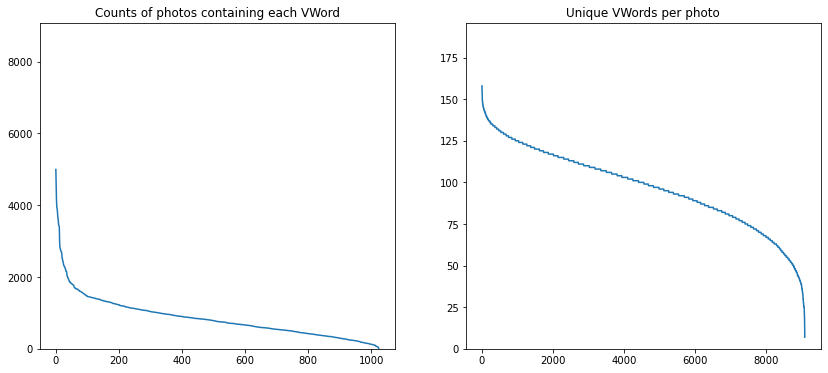

In [25]:
plot_stats(bovw);

In [12]:
#export
@call_parse
def train(
        path:Path, # directory containing all the images (we will find images in nested subdirectories)
        backbone:str    = 'resnet18', # backbone
        pretrained:bool = False, # use an ImageNet pretrained model as a starting point
        preserve_colors = True, # are colors important in your dataset (disables the B&W and color jitter augmentations)
        samples:int     = 50000, # how many samples to show to the model during training (default is 50k or the image count, whichever is higher)
        size:int        = 224, # the size of the image crops we train on
        n_vwords:int    = 1024, # how many visual-words to use for the Bag-of-Visual-Words representation
        lr:float        = 5e-4, # lr
        project:str     = None, # W&B project name
    ):
    "Pretrain a model on images in `path`."
    import wandb
    wandb.login()
    
    dls, test_dls = get_dataloaders(path, size)
    
    if project is None: project = f"{path.name}-mlqa-training"
        
    samples = math.ceil(samples / len(dls.items)) * len(dls.items)

    if wandb:
        run = wandb.init(project=project, config=dict(
            backbone=backbone, pretrained=pretrained,
            preserve_colors=preserve_colors,
            size=size, lr=lr, samples=samples))
    
    learn = train_model(dls, samples, size, backbone, lr, pretrained, preserve_colors)
    
    _pretrained = "-pretrained" if pretrained else ""
    _bw = "bw" if preserve_colors else ""
    name = f"mlqa-model-{backbone}{_pretrained}-{size}{_bw}x{samples}-lr{lr*1000}e-3"
    learn.save(name, with_opt=False)
    
    features = extract_features(test_dls, learn.model)
    
    _, bovw = calculate_bovw(features, n_vwords=n_vwords)

    stats_fname = path/'models'/'stats.png'
    plot_stats(bovw).savefig(stats_fname)
        
    np.savez_compressed(path/'models'/f'{name}-{n_vwords}vw.npz',
                       fnames = test_dls.items,
                       bovw = np.packbits(bovw, axis=1))
    
    if wandb:
        wandb.log({'VWords statistics': wandb.Image(str(stats_fname))})
        run.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▅▄▃▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,6
eps_0,1e-05
lr_0,0.0


WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> list index out of range


epoch,train_loss,valid_loss,time
0,766.233826,None,00:24
1,572.160339,None,00:24
2,535.525208,None,00:24
3,492.737518,None,00:24
4,468.927490,None,00:24
5,448.629913,None,00:24


/opt/miniconda3/lib/python3.9/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Calculating KMeans:
Init 1/3 with method k-means++
Inertia for init 1/3: 60.307926177978516
Init 2/3 with method k-means++
Inertia for init 2/3: 60.12995529174805
Init 3/3 with method k-means++
Inertia for init 3/3: 59.8294792175293
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 1/173950: mean batch inertia: 0.01990477554500103
[MiniBatchKMeans] Reassigning 325 cluster centers.
Minibatch step 2/173950: mean batch inertia: 0.02291550114750862, ewa inertia: 0.02291550114750862
Minibatch step 3/173950: mean batch inertia: 0.02132205106317997, ewa inertia: 0.022913669070256812
Minibatch step 4/173950: mean batch inertia: 0.020782243460416794, ewa inertia: 0.022911218452937754
Minibatch step 5/173950: mean batch inertia: 0.01879042573273182, ewa inertia: 0.02290648055077417
Minibatch step 6/173950: mean batch inertia: 0.01736557111144066, ewa inertia: 0.022900109862267534
Minibatch step 7/173950: mean batch inertia: 0.01782725751399994, ewa inertia: 0.022894277324756355
M

Minibatch step 96/173950: mean batch inertia: 0.01569874957203865, ewa inertia: 0.02216299552875377
Minibatch step 97/173950: mean batch inertia: 0.015614122152328491, ewa inertia: 0.022155465928638953
Minibatch step 98/173950: mean batch inertia: 0.014377260580658913, ewa inertia: 0.02214652289790453
Minibatch step 99/173950: mean batch inertia: 0.01458453293889761, ewa inertia: 0.022137828461901453
Minibatch step 100/173950: mean batch inertia: 0.014022978022694588, ewa inertia: 0.02212849837177958
Minibatch step 101/173950: mean batch inertia: 0.013822217471897602, ewa inertia: 0.022118948183522374
Minibatch step 102/173950: mean batch inertia: 0.01591341570019722, ewa inertia: 0.022111813341326895
Minibatch step 103/173950: mean batch inertia: 0.0152976606041193, ewa inertia: 0.022103978734932278
Minibatch step 104/173950: mean batch inertia: 0.014924978837370872, ewa inertia: 0.022095724643679336
Minibatch step 105/173950: mean batch inertia: 0.01518308650702238, ewa inertia: 0.02

Minibatch step 203/173950: mean batch inertia: 0.014407294802367687, ewa inertia: 0.021301976252076277
Minibatch step 204/173950: mean batch inertia: 0.013863114640116692, ewa inertia: 0.02129342338350973
Minibatch step 205/173950: mean batch inertia: 0.015287043526768684, ewa inertia: 0.021286517518048692
Minibatch step 206/173950: mean batch inertia: 0.014406396076083183, ewa inertia: 0.021278607063803863
Minibatch step 207/173950: mean batch inertia: 0.01508248783648014, ewa inertia: 0.021271483044546836
Minibatch step 208/173950: mean batch inertia: 0.01447608508169651, ewa inertia: 0.021263670001548402
Minibatch step 209/173950: mean batch inertia: 0.015580546110868454, ewa inertia: 0.021257135801260787
Minibatch step 210/173950: mean batch inertia: 0.014386569149792194, ewa inertia: 0.021249236332684406
Minibatch step 211/173950: mean batch inertia: 0.014077008701860905, ewa inertia: 0.021240990027879224
Minibatch step 212/173950: mean batch inertia: 0.014902453869581223, ewa ine

Minibatch step 285/173950: mean batch inertia: 0.014647944830358028, ewa inertia: 0.02068705667476184
Minibatch step 286/173950: mean batch inertia: 0.01414453610777855, ewa inertia: 0.02067953437882164
Minibatch step 287/173950: mean batch inertia: 0.014607030898332596, ewa inertia: 0.020672552487391502
Minibatch step 288/173950: mean batch inertia: 0.014257501810789108, ewa inertia: 0.020665176750599125
Minibatch step 289/173950: mean batch inertia: 0.014867685735225677, ewa inertia: 0.020658511056134463
Minibatch step 290/173950: mean batch inertia: 0.014649337157607079, ewa inertia: 0.020651601978209824
Minibatch step 291/173950: mean batch inertia: 0.015163350850343704, ewa inertia: 0.020645291833861747
Minibatch step 292/173950: mean batch inertia: 0.014471338130533695, ewa inertia: 0.020638193299527458
Minibatch step 293/173950: mean batch inertia: 0.01494145393371582, ewa inertia: 0.020631643444778806
Minibatch step 294/173950: mean batch inertia: 0.01451167929917574, ewa inert

Minibatch step 396/173950: mean batch inertia: 0.015072041191160679, ewa inertia: 0.01992765530683092
Minibatch step 397/173950: mean batch inertia: 0.014799878932535648, ewa inertia: 0.019921759620144468
Minibatch step 398/173950: mean batch inertia: 0.013786439783871174, ewa inertia: 0.019914705505293208
Minibatch step 399/173950: mean batch inertia: 0.014421867206692696, ewa inertia: 0.019908390086822495
Minibatch step 400/173950: mean batch inertia: 0.013544417917728424, ewa inertia: 0.019901073077801125
Minibatch step 401/173950: mean batch inertia: 0.014557640068233013, ewa inertia: 0.019894929438813203
Minibatch step 402/173950: mean batch inertia: 0.013882248662412167, ewa inertia: 0.019888016328838087
Minibatch step 403/173950: mean batch inertia: 0.013954606838524342, ewa inertia: 0.019881194361422997
Minibatch step 404/173950: mean batch inertia: 0.014961724169552326, ewa inertia: 0.01987553817581787
Minibatch step 405/173950: mean batch inertia: 0.01412762701511383, ewa ine

Minibatch step 483/173950: mean batch inertia: 0.015151862986385822, ewa inertia: 0.01941009168895327
Minibatch step 484/173950: mean batch inertia: 0.013492773286998272, ewa inertia: 0.01940328822234798
Minibatch step 485/173950: mean batch inertia: 0.015199041925370693, ewa inertia: 0.019398454369014613
Minibatch step 486/173950: mean batch inertia: 0.014859759248793125, ewa inertia: 0.019393235981463957
Minibatch step 487/173950: mean batch inertia: 0.014026874676346779, ewa inertia: 0.019387065980552863
Minibatch step 488/173950: mean batch inertia: 0.014206284657120705, ewa inertia: 0.01938110935115945
Minibatch step 489/173950: mean batch inertia: 0.014110748656094074, ewa inertia: 0.019375049727432786
Minibatch step 490/173950: mean batch inertia: 0.014453860931098461, ewa inertia: 0.019369391565853527
Minibatch step 491/173950: mean batch inertia: 0.014511095359921455, ewa inertia: 0.019363805715346523
Minibatch step 492/173950: mean batch inertia: 0.014036533422768116, ewa ine

Minibatch step 572/173950: mean batch inertia: 0.015500951558351517, ewa inertia: 0.018923314999175194
Minibatch step 573/173950: mean batch inertia: 0.014398177154362202, ewa inertia: 0.018918112199170153
Minibatch step 574/173950: mean batch inertia: 0.014263785444200039, ewa inertia: 0.018912760863565654
Minibatch step 575/173950: mean batch inertia: 0.013710052706301212, ewa inertia: 0.018906779023684716
Minibatch step 576/173950: mean batch inertia: 0.013635414652526379, ewa inertia: 0.018900718245976417
Minibatch step 577/173950: mean batch inertia: 0.014362993650138378, ewa inertia: 0.018895500974291057
Minibatch step 578/173950: mean batch inertia: 0.014425108209252357, ewa inertia: 0.01889036111771693
Minibatch step 579/173950: mean batch inertia: 0.014753771014511585, ewa inertia: 0.01888560505243276
Minibatch step 580/173950: mean batch inertia: 0.013153692707419395, ewa inertia: 0.018879014757374298
Minibatch step 581/173950: mean batch inertia: 0.0133476871997118, ewa iner

Minibatch step 670/173950: mean batch inertia: 0.014888966456055641, ewa inertia: 0.01843467966340134
Minibatch step 671/173950: mean batch inertia: 0.014171896502375603, ewa inertia: 0.018429778507014008
Minibatch step 672/173950: mean batch inertia: 0.015008716844022274, ewa inertia: 0.018425845124154114
Minibatch step 673/173950: mean batch inertia: 0.014390125870704651, ewa inertia: 0.018421205035636976
Minibatch step 674/173950: mean batch inertia: 0.014722068794071674, ewa inertia: 0.018416951935131248
Minibatch step 675/173950: mean batch inertia: 0.014803976751863956, ewa inertia: 0.018412797898735813
Minibatch step 676/173950: mean batch inertia: 0.014241943135857582, ewa inertia: 0.018408002437486783
Minibatch step 677/173950: mean batch inertia: 0.013991137966513634, ewa inertia: 0.018402924125338088
Minibatch step 678/173950: mean batch inertia: 0.013934641145169735, ewa inertia: 0.01839778669449974
Minibatch step 679/173950: mean batch inertia: 0.014483797363936901, ewa in

Minibatch step 777/173950: mean batch inertia: 0.014820066280663013, ewa inertia: 0.017966343729538422
Minibatch step 778/173950: mean batch inertia: 0.014198106713593006, ewa inertia: 0.017962011180069674
Minibatch step 779/173950: mean batch inertia: 0.014989608898758888, ewa inertia: 0.017958593645591266
Minibatch step 780/173950: mean batch inertia: 0.015168687328696251, ewa inertia: 0.017955385936766165
Minibatch step 781/173950: mean batch inertia: 0.014647490344941616, ewa inertia: 0.017951582667165983
Minibatch step 782/173950: mean batch inertia: 0.014190451242029667, ewa inertia: 0.01794725828738602
Minibatch step 783/173950: mean batch inertia: 0.013891837559640408, ewa inertia: 0.01794259554699968
Minibatch step 784/173950: mean batch inertia: 0.014197667129337788, ewa inertia: 0.017938289796709087
Minibatch step 785/173950: mean batch inertia: 0.015108160674571991, ewa inertia: 0.017935035841511283
Minibatch step 786/173950: mean batch inertia: 0.013619478791952133, ewa in

Minibatch step 861/173950: mean batch inertia: 0.013598744757473469, ewa inertia: 0.01763271287297289
Minibatch step 862/173950: mean batch inertia: 0.013455978594720364, ewa inertia: 0.017627910651721472
Minibatch step 863/173950: mean batch inertia: 0.01395832933485508, ewa inertia: 0.01762369153213912
Minibatch step 864/173950: mean batch inertia: 0.013771234080195427, ewa inertia: 0.017619262149800332
Minibatch step 865/173950: mean batch inertia: 0.014695588499307632, ewa inertia: 0.017615900641310387
Minibatch step 866/173950: mean batch inertia: 0.014775167219340801, ewa inertia: 0.017612634493765492
Minibatch step 867/173950: mean batch inertia: 0.013927602209150791, ewa inertia: 0.017608397609355234
Minibatch step 868/173950: mean batch inertia: 0.01418224535882473, ewa inertia: 0.017604458373566702
Minibatch step 869/173950: mean batch inertia: 0.01512193027883768, ewa inertia: 0.01760160407439909
Minibatch step 870/173950: mean batch inertia: 0.013756437227129936, ewa inerti

Minibatch step 943/173950: mean batch inertia: 0.013307278975844383, ewa inertia: 0.01731946411646848
Minibatch step 944/173950: mean batch inertia: 0.014344871044158936, ewa inertia: 0.0173160440631171
Minibatch step 945/173950: mean batch inertia: 0.01513852272182703, ewa inertia: 0.01731354044699888
Minibatch step 946/173950: mean batch inertia: 0.015518147498369217, ewa inertia: 0.01731147618492278
Minibatch step 947/173950: mean batch inertia: 0.01365176122635603, ewa inertia: 0.017307268409235528
Minibatch step 948/173950: mean batch inertia: 0.014346185140311718, ewa inertia: 0.017303863888848567
Minibatch step 949/173950: mean batch inertia: 0.013941433280706406, ewa inertia: 0.01729999791733898
Minibatch step 950/173950: mean batch inertia: 0.014192849397659302, ewa inertia: 0.017296425457695042
Minibatch step 951/173950: mean batch inertia: 0.014320026151835918, ewa inertia: 0.017293003327617552
Minibatch step 952/173950: mean batch inertia: 0.013598713092505932, ewa inertia:

Minibatch step 1029/173950: mean batch inertia: 0.013851474039256573, ewa inertia: 0.017034825471509935
Minibatch step 1030/173950: mean batch inertia: 0.013297549448907375, ewa inertia: 0.017030528519599065
Minibatch step 1031/173950: mean batch inertia: 0.014012029394507408, ewa inertia: 0.01702705798504259
Minibatch step 1032/173950: mean batch inertia: 0.014334392733871937, ewa inertia: 0.01702396207962207
Minibatch step 1033/173950: mean batch inertia: 0.015010385774075985, ewa inertia: 0.017021646960133578
Minibatch step 1034/173950: mean batch inertia: 0.013953838497400284, ewa inertia: 0.017018119731918052
Minibatch step 1035/173950: mean batch inertia: 0.014583363197743893, ewa inertia: 0.01701532035834255
Minibatch step 1036/173950: mean batch inertia: 0.01405311655253172, ewa inertia: 0.017011914549612664
Minibatch step 1037/173950: mean batch inertia: 0.01373268198221922, ewa inertia: 0.017008144235469036
Minibatch step 1038/173950: mean batch inertia: 0.014258491806685925,

Minibatch step 1119/173950: mean batch inertia: 0.013665542006492615, ewa inertia: 0.016752271450328506
Minibatch step 1120/173950: mean batch inertia: 0.014458877965807915, ewa inertia: 0.016749634609630602
Minibatch step 1121/173950: mean batch inertia: 0.014489692635834217, ewa inertia: 0.016747036229975466
Minibatch step 1122/173950: mean batch inertia: 0.013915766961872578, ewa inertia: 0.016743780963889097
Minibatch step 1123/173950: mean batch inertia: 0.014509782195091248, ewa inertia: 0.016741212412564436
Minibatch step 1124/173950: mean batch inertia: 0.013768747448921204, ewa inertia: 0.0167377948060167
Minibatch step 1125/173950: mean batch inertia: 0.014248187653720379, ewa inertia: 0.016734932367667037
Minibatch step 1126/173950: mean batch inertia: 0.013144760392606258, ewa inertia: 0.01673080454937497
Minibatch step 1127/173950: mean batch inertia: 0.01442840974777937, ewa inertia: 0.016728157359367474
Minibatch step 1128/173950: mean batch inertia: 0.01407504454255104,

Minibatch step 1225/173950: mean batch inertia: 0.013303978368639946, ewa inertia: 0.016466560997838855
Minibatch step 1226/173950: mean batch inertia: 0.013752573169767857, ewa inertia: 0.01646344057667826
Minibatch step 1227/173950: mean batch inertia: 0.014573256485164165, ewa inertia: 0.01646126732800869
Minibatch step 1228/173950: mean batch inertia: 0.014252343215048313, ewa inertia: 0.016458727606395742
Minibatch step 1229/173950: mean batch inertia: 0.014660995453596115, ewa inertia: 0.016456660654807876
Minibatch step 1230/173950: mean batch inertia: 0.014671863056719303, ewa inertia: 0.016454608574789368
Minibatch step 1231/173950: mean batch inertia: 0.01342995185405016, ewa inertia: 0.016451130960506315
Minibatch step 1232/173950: mean batch inertia: 0.014365174807608128, ewa inertia: 0.016448732621924155
Minibatch step 1233/173950: mean batch inertia: 0.014713342301547527, ewa inertia: 0.01644673734817179
Minibatch step 1234/173950: mean batch inertia: 0.013942234218120575

Minibatch step 1316/173950: mean batch inertia: 0.014109199866652489, ewa inertia: 0.016248315654975025
Minibatch step 1317/173950: mean batch inertia: 0.013786986470222473, ewa inertia: 0.016245485729360822
Minibatch step 1318/173950: mean batch inertia: 0.013353743590414524, ewa inertia: 0.016242160934286938
Minibatch step 1319/173950: mean batch inertia: 0.014264605939388275, ewa inertia: 0.0162398872304816
Minibatch step 1320/173950: mean batch inertia: 0.01452229730784893, ewa inertia: 0.0162379124228261
Minibatch step 1321/173950: mean batch inertia: 0.01452010590583086, ewa inertia: 0.01623593736614014
Minibatch step 1322/173950: mean batch inertia: 0.015130890533328056, ewa inertia: 0.01623466683298414
Minibatch step 1323/173950: mean batch inertia: 0.013466986827552319, ewa inertia: 0.016231484678972473
Minibatch step 1324/173950: mean batch inertia: 0.014576363377273083, ewa inertia: 0.016229581694928198
Minibatch step 1325/173950: mean batch inertia: 0.015085109509527683, ew

Minibatch step 1418/173950: mean batch inertia: 0.01380422804504633, ewa inertia: 0.016014356255314076
Minibatch step 1419/173950: mean batch inertia: 0.014585710130631924, ewa inertia: 0.016012713662244073
Minibatch step 1420/173950: mean batch inertia: 0.015175078995525837, ewa inertia: 0.016011750587571504
Minibatch step 1421/173950: mean batch inertia: 0.014908084645867348, ewa inertia: 0.016010481642101997
Minibatch step 1422/173950: mean batch inertia: 0.01388186402618885, ewa inertia: 0.016008034253288086
Minibatch step 1423/173950: mean batch inertia: 0.01406357903033495, ewa inertia: 0.016005798606112082
Minibatch step 1424/173950: mean batch inertia: 0.014708076603710651, ewa inertia: 0.016004306543710406
Minibatch step 1425/173950: mean batch inertia: 0.013927537947893143, ewa inertia: 0.016001918768568223
Minibatch step 1426/173950: mean batch inertia: 0.014169517904520035, ewa inertia: 0.015999811956455164
Minibatch step 1427/173950: mean batch inertia: 0.01388156693428754

Minibatch step 1502/173950: mean batch inertia: 0.013929123058915138, ewa inertia: 0.015849554626519977
Minibatch step 1503/173950: mean batch inertia: 0.014418828301131725, ewa inertia: 0.015847909641728747
Minibatch step 1504/173950: mean batch inertia: 0.014310663565993309, ewa inertia: 0.015846142185318608
Minibatch step 1505/173950: mean batch inertia: 0.014778614044189453, ewa inertia: 0.01584491478946714
Minibatch step 1506/173950: mean batch inertia: 0.01363628264516592, ewa inertia: 0.015842375403546625
Minibatch step 1507/173950: mean batch inertia: 0.015615401789546013, ewa inertia: 0.015842114439491923
Minibatch step 1508/173950: mean batch inertia: 0.01492372713983059, ewa inertia: 0.015841058519073328
Minibatch step 1509/173950: mean batch inertia: 0.013498837128281593, ewa inertia: 0.015838365538244515
Minibatch step 1510/173950: mean batch inertia: 0.014118563383817673, ewa inertia: 0.01583638818706438
Minibatch step 1511/173950: mean batch inertia: 0.014416731894016266

Minibatch step 1593/173950: mean batch inertia: 0.014384453184902668, ewa inertia: 0.015689413529747086
Minibatch step 1594/173950: mean batch inertia: 0.013671083375811577, ewa inertia: 0.015687092944497487
Minibatch step 1595/173950: mean batch inertia: 0.014301931485533714, ewa inertia: 0.015685500348140684
Minibatch step 1596/173950: mean batch inertia: 0.014523252844810486, ewa inertia: 0.01568416404822595
Minibatch step 1597/173950: mean batch inertia: 0.013613124378025532, ewa inertia: 0.015681782859944822
Minibatch step 1598/173950: mean batch inertia: 0.014172215014696121, ewa inertia: 0.015680047226719444
Minibatch step 1599/173950: mean batch inertia: 0.014402778819203377, ewa inertia: 0.0156785786809414
Minibatch step 1600/173950: mean batch inertia: 0.01426689326763153, ewa inertia: 0.015676955588534634
Minibatch step 1601/173950: mean batch inertia: 0.014079763554036617, ewa inertia: 0.01567511920895679
Minibatch step 1602/173950: mean batch inertia: 0.014252351596951485,

Minibatch step 1690/173950: mean batch inertia: 0.014490426518023014, ewa inertia: 0.015527485471330926
Minibatch step 1691/173950: mean batch inertia: 0.014767530374228954, ewa inertia: 0.015526611709134363
Minibatch step 1692/173950: mean batch inertia: 0.014547821134328842, ewa inertia: 0.015525486339746254
Minibatch step 1693/173950: mean batch inertia: 0.014501591213047504, ewa inertia: 0.015524309111172663
Minibatch step 1694/173950: mean batch inertia: 0.013688923791050911, ewa inertia: 0.01552219886766622
Minibatch step 1695/173950: mean batch inertia: 0.014719462022185326, ewa inertia: 0.015521275916939204
Minibatch step 1696/173950: mean batch inertia: 0.014250513166189194, ewa inertia: 0.01551981485107276
Minibatch step 1697/173950: mean batch inertia: 0.015098807401955128, ewa inertia: 0.015519330795639863
Minibatch step 1698/173950: mean batch inertia: 0.015223200432956219, ewa inertia: 0.015518990318265405
Minibatch step 1699/173950: mean batch inertia: 0.0152650801464915

Minibatch step 1796/173950: mean batch inertia: 0.013057657517492771, ewa inertia: 0.01538758796740874
Minibatch step 1797/173950: mean batch inertia: 0.014057958498597145, ewa inertia: 0.01538605921923702
Minibatch step 1798/173950: mean batch inertia: 0.014364183880388737, ewa inertia: 0.015384884312924674
Minibatch step 1799/173950: mean batch inertia: 0.014415917918086052, ewa inertia: 0.01538377023893691
Minibatch step 1800/173950: mean batch inertia: 0.015104023739695549, ewa inertia: 0.01538344859899188
Minibatch step 1801/173950: mean batch inertia: 0.014195193536579609, ewa inertia: 0.015382082396755235
Minibatch step 1802/173950: mean batch inertia: 0.014212396927177906, ewa inertia: 0.015380737545001383
Minibatch step 1803/173950: mean batch inertia: 0.014244887046515942, ewa inertia: 0.015379431595175783
Minibatch step 1804/173950: mean batch inertia: 0.013986599631607533, ewa inertia: 0.015377830179617719
Minibatch step 1805/173950: mean batch inertia: 0.014602788724005222

Minibatch step 1880/173950: mean batch inertia: 0.014800517819821835, ewa inertia: 0.015283346187471245
Minibatch step 1881/173950: mean batch inertia: 0.01411267276853323, ewa inertia: 0.015282000199817646
Minibatch step 1882/173950: mean batch inertia: 0.01591227762401104, ewa inertia: 0.015282724864457316
Minibatch step 1883/173950: mean batch inertia: 0.01437852531671524, ewa inertia: 0.015281685256477872
Minibatch step 1884/173950: mean batch inertia: 0.0137556791305542, ewa inertia: 0.01527993072325658
Minibatch step 1885/173950: mean batch inertia: 0.014633363112807274, ewa inertia: 0.0152791873288933
Minibatch step 1886/173950: mean batch inertia: 0.014643289148807526, ewa inertia: 0.01527845620176126
Minibatch step 1887/173950: mean batch inertia: 0.01338953711092472, ewa inertia: 0.015276284407532583
Minibatch step 1888/173950: mean batch inertia: 0.013507197611033916, ewa inertia: 0.015274250391087252
Minibatch step 1889/173950: mean batch inertia: 0.0147600332275033, ewa in

Minibatch step 1980/173950: mean batch inertia: 0.013999058865010738, ewa inertia: 0.015160468113601604
Minibatch step 1981/173950: mean batch inertia: 0.012998593039810658, ewa inertia: 0.015157982486858165
Minibatch step 1982/173950: mean batch inertia: 0.014173876494169235, ewa inertia: 0.015156851006041598
Minibatch step 1983/173950: mean batch inertia: 0.013874384574592113, ewa inertia: 0.015155376483809385
Minibatch step 1984/173950: mean batch inertia: 0.014243772253394127, ewa inertia: 0.015154328362258782
Minibatch step 1985/173950: mean batch inertia: 0.014793474227190018, ewa inertia: 0.01515391346840137
Minibatch step 1986/173950: mean batch inertia: 0.015019392594695091, ewa inertia: 0.015153758802349992
Minibatch step 1987/173950: mean batch inertia: 0.013637109659612179, ewa inertia: 0.015152015027367197
Minibatch step 1988/173950: mean batch inertia: 0.014535934664309025, ewa inertia: 0.015151306685869998
Minibatch step 1989/173950: mean batch inertia: 0.014792934060096

Minibatch step 2063/173950: mean batch inertia: 0.013204100541770458, ewa inertia: 0.015073147409628881
Minibatch step 2064/173950: mean batch inertia: 0.013855872675776482, ewa inertia: 0.015071747841878988
Minibatch step 2065/173950: mean batch inertia: 0.01495581679046154, ewa inertia: 0.015071614549569321
Minibatch step 2066/173950: mean batch inertia: 0.014299607835710049, ewa inertia: 0.015070726930965754
Minibatch step 2067/173950: mean batch inertia: 0.014069744385778904, ewa inertia: 0.01506957604624804
Minibatch step 2068/173950: mean batch inertia: 0.014375286176800728, ewa inertia: 0.015068777782977364
Minibatch step 2069/173950: mean batch inertia: 0.01378034520894289, ewa inertia: 0.015067296401142695
Minibatch step 2070/173950: mean batch inertia: 0.013754788786172867, ewa inertia: 0.015065787338908577
Minibatch step 2071/173950: mean batch inertia: 0.01407874096184969, ewa inertia: 0.015064652477370287
Minibatch step 2072/173950: mean batch inertia: 0.01487964391708374,

Minibatch step 2162/173950: mean batch inertia: 0.014757795259356499, ewa inertia: 0.014966632768531602
Minibatch step 2163/173950: mean batch inertia: 0.01419430784881115, ewa inertia: 0.014965744784069247
Minibatch step 2164/173950: mean batch inertia: 0.014008487574756145, ewa inertia: 0.014964644172776456
Minibatch step 2165/173950: mean batch inertia: 0.013239830732345581, ewa inertia: 0.014962661059845022
Minibatch step 2166/173950: mean batch inertia: 0.014643145725131035, ewa inertia: 0.014962293695481311
Minibatch step 2167/173950: mean batch inertia: 0.01504525262862444, ewa inertia: 0.014962389077932094
Minibatch step 2168/173950: mean batch inertia: 0.013109870254993439, ewa inertia: 0.014960259135094581
Minibatch step 2169/173950: mean batch inertia: 0.01359952986240387, ewa inertia: 0.014958694629766876
Minibatch step 2170/173950: mean batch inertia: 0.014054998755455017, ewa inertia: 0.014957655600888492
Minibatch step 2171/173950: mean batch inertia: 0.01505291089415550

Minibatch step 2271/173950: mean batch inertia: 0.014577974565327168, ewa inertia: 0.014875524251595803
Minibatch step 2272/173950: mean batch inertia: 0.014196135103702545, ewa inertia: 0.014874743120504704
Minibatch step 2273/173950: mean batch inertia: 0.01419209036976099, ewa inertia: 0.01487395823706981
Minibatch step 2274/173950: mean batch inertia: 0.013986971229314804, ewa inertia: 0.01487293841929482
Minibatch step 2275/173950: mean batch inertia: 0.01499346923083067, ewa inertia: 0.014873077000201827
Minibatch step 2276/173950: mean batch inertia: 0.013838793151080608, ewa inertia: 0.01487188782714236
Minibatch step 2277/173950: mean batch inertia: 0.013628809712827206, ewa inertia: 0.01487045859182595
Minibatch step 2278/173950: mean batch inertia: 0.01424963679164648, ewa inertia: 0.014869744798837566
Minibatch step 2279/173950: mean batch inertia: 0.014529217034578323, ewa inertia: 0.014869353275327263
Minibatch step 2280/173950: mean batch inertia: 0.014408781193196774, e

Minibatch step 2373/173950: mean batch inertia: 0.014074784703552723, ewa inertia: 0.014802785141553955
Minibatch step 2374/173950: mean batch inertia: 0.014377705752849579, ewa inertia: 0.014802296404388031
Minibatch step 2375/173950: mean batch inertia: 0.013482507318258286, ewa inertia: 0.014800778970245811
Minibatch step 2376/173950: mean batch inertia: 0.015440339222550392, ewa inertia: 0.014801514307863807
Minibatch step 2377/173950: mean batch inertia: 0.013460728339850903, ewa inertia: 0.014799972732450999
Minibatch step 2378/173950: mean batch inertia: 0.015369785018265247, ewa inertia: 0.01480062787699359
Minibatch step 2379/173950: mean batch inertia: 0.014513366855680943, ewa inertia: 0.014800297597189
Minibatch step 2380/173950: mean batch inertia: 0.014581124298274517, ewa inertia: 0.014800045601585815
Minibatch step 2381/173950: mean batch inertia: 0.013874487951397896, ewa inertia: 0.014798981437020624
Minibatch step 2382/173950: mean batch inertia: 0.014835073612630367

Minibatch step 2470/173950: mean batch inertia: 0.01365717500448227, ewa inertia: 0.014740559179156868
Minibatch step 2471/173950: mean batch inertia: 0.014887015335261822, ewa inertia: 0.014740727567859236
Minibatch step 2472/173950: mean batch inertia: 0.0140497712418437, ewa inertia: 0.014739933137346893
Minibatch step 2473/173950: mean batch inertia: 0.015139841474592686, ewa inertia: 0.014740392933969755
Minibatch step 2474/173950: mean batch inertia: 0.013689994812011719, ewa inertia: 0.014739185233444018
Minibatch step 2475/173950: mean batch inertia: 0.013525309972465038, ewa inertia: 0.014737789574255165
Minibatch step 2476/173950: mean batch inertia: 0.014516125433146954, ewa inertia: 0.014737534714793636
Minibatch step 2477/173950: mean batch inertia: 0.01427149772644043, ewa inertia: 0.014736998886421437
Minibatch step 2478/173950: mean batch inertia: 0.01338140107691288, ewa inertia: 0.014735440281019344
Minibatch step 2479/173950: mean batch inertia: 0.014024030417203903,

Minibatch step 2573/173950: mean batch inertia: 0.014252413995563984, ewa inertia: 0.014685516004923023
Minibatch step 2574/173950: mean batch inertia: 0.014433207921683788, ewa inertia: 0.014685225912434844
Minibatch step 2575/173950: mean batch inertia: 0.014250393025577068, ewa inertia: 0.014684725961135342
Minibatch step 2576/173950: mean batch inertia: 0.01513143815100193, ewa inertia: 0.014685239570723247
Minibatch step 2577/173950: mean batch inertia: 0.014606458134949207, ewa inertia: 0.014685148991371083
Minibatch step 2578/173950: mean batch inertia: 0.014215605333447456, ewa inertia: 0.014684609131187904
Minibatch step 2579/173950: mean batch inertia: 0.014691156335175037, ewa inertia: 0.014684616658868629
Minibatch step 2580/173950: mean batch inertia: 0.014163474552333355, ewa inertia: 0.014684017473109543
Minibatch step 2581/173950: mean batch inertia: 0.01468975655734539, ewa inertia: 0.01468402407165052
Minibatch step 2582/173950: mean batch inertia: 0.01414976548403501

Minibatch step 2660/173950: mean batch inertia: 0.01348805706948042, ewa inertia: 0.01463762372448954
Minibatch step 2661/173950: mean batch inertia: 0.014978475868701935, ewa inertia: 0.014638015620957326
Minibatch step 2662/173950: mean batch inertia: 0.014972560107707977, ewa inertia: 0.014638400265164208
Minibatch step 2663/173950: mean batch inertia: 0.013941231183707714, ewa inertia: 0.014637598691505037
Minibatch step 2664/173950: mean batch inertia: 0.014159775339066982, ewa inertia: 0.014637049311701431
Minibatch step 2665/173950: mean batch inertia: 0.014283761382102966, ewa inertia: 0.014636643117126829
Minibatch step 2666/173950: mean batch inertia: 0.014474340714514256, ewa inertia: 0.01463645650912281
Minibatch step 2667/173950: mean batch inertia: 0.01464826613664627, ewa inertia: 0.014636470087301475
Minibatch step 2668/173950: mean batch inertia: 0.014130889438092709, ewa inertia: 0.014635888793406248
Minibatch step 2669/173950: mean batch inertia: 0.01349696796387434,

Minibatch step 2742/173950: mean batch inertia: 0.013810239732265472, ewa inertia: 0.014596001484517717
Minibatch step 2743/173950: mean batch inertia: 0.014351453632116318, ewa inertia: 0.01459572031439399
Minibatch step 2744/173950: mean batch inertia: 0.01494403276592493, ewa inertia: 0.014596120788387651
Minibatch step 2745/173950: mean batch inertia: 0.01397124957293272, ewa inertia: 0.014595402339563678
Minibatch step 2746/173950: mean batch inertia: 0.014143934473395348, ewa inertia: 0.014594883262113017
Minibatch step 2747/173950: mean batch inertia: 0.014412060379981995, ewa inertia: 0.014594673060584424
Minibatch step 2748/173950: mean batch inertia: 0.014043102040886879, ewa inertia: 0.01459403888902933
Minibatch step 2749/173950: mean batch inertia: 0.014202413149178028, ewa inertia: 0.014593588615364493
Minibatch step 2750/173950: mean batch inertia: 0.015946518629789352, ewa inertia: 0.014595144153455766
Minibatch step 2751/173950: mean batch inertia: 0.013755650259554386

Minibatch step 2835/173950: mean batch inertia: 0.013148163445293903, ewa inertia: 0.014554817080407869
Minibatch step 2836/173950: mean batch inertia: 0.014149172231554985, ewa inertia: 0.014554350688201921
Minibatch step 2837/173950: mean batch inertia: 0.013827383518218994, ewa inertia: 0.014553514854040541
Minibatch step 2838/173950: mean batch inertia: 0.01390068233013153, ewa inertia: 0.014552764256561488
Minibatch step 2839/173950: mean batch inertia: 0.014236456714570522, ewa inertia: 0.014552400580373602
Minibatch step 2840/173950: mean batch inertia: 0.014063716866075993, ewa inertia: 0.014551838713814306
Minibatch step 2841/173950: mean batch inertia: 0.013648241758346558, ewa inertia: 0.01455079979866836
Minibatch step 2842/173950: mean batch inertia: 0.015147645957767963, ewa inertia: 0.014551486025542782
Minibatch step 2843/173950: mean batch inertia: 0.014415992423892021, ewa inertia: 0.014551330241092557
Minibatch step 2844/173950: mean batch inertia: 0.0139790903776884

Minibatch step 2919/173950: mean batch inertia: 0.013851041905581951, ewa inertia: 0.0145135755510823
Minibatch step 2920/173950: mean batch inertia: 0.015316358767449856, ewa inertia: 0.014514498555124475
Minibatch step 2921/173950: mean batch inertia: 0.013774174265563488, ewa inertia: 0.014513647363547655
Minibatch step 2922/173950: mean batch inertia: 0.014402640983462334, ewa inertia: 0.01451351973340363
Minibatch step 2923/173950: mean batch inertia: 0.015075961127877235, ewa inertia: 0.014514166403226817
Minibatch step 2924/173950: mean batch inertia: 0.014172229915857315, ewa inertia: 0.01451377326003003
Minibatch step 2925/173950: mean batch inertia: 0.014286314137279987, ewa inertia: 0.014513511737759199
Minibatch step 2926/173950: mean batch inertia: 0.013869090937077999, ewa inertia: 0.014512770811701249
Minibatch step 2927/173950: mean batch inertia: 0.015368614345788956, ewa inertia: 0.014513754822110692
Minibatch step 2928/173950: mean batch inertia: 0.014968089759349823

Minibatch step 3002/173950: mean batch inertia: 0.013351974077522755, ewa inertia: 0.014469690652168654
Minibatch step 3003/173950: mean batch inertia: 0.014074000529944897, ewa inertia: 0.014469235705459734
Minibatch step 3004/173950: mean batch inertia: 0.0138865290209651, ewa inertia: 0.014468565735517382
Minibatch step 3005/173950: mean batch inertia: 0.01419532485306263, ewa inertia: 0.014468251575437983
Minibatch step 3006/173950: mean batch inertia: 0.014355219900608063, ewa inertia: 0.014468121616701135
Minibatch step 3007/173950: mean batch inertia: 0.014087896794080734, ewa inertia: 0.014467684451298247
Minibatch step 3008/173950: mean batch inertia: 0.014644734561443329, ewa inertia: 0.014467888015553204
Minibatch step 3009/173950: mean batch inertia: 0.014513829723000526, ewa inertia: 0.014467940837262496
Minibatch step 3010/173950: mean batch inertia: 0.013952620327472687, ewa inertia: 0.01446734834491356
Minibatch step 3011/173950: mean batch inertia: 0.013843325898051262

Calculating BoVW features:



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,6
eps_0,1e-05
lr_0,0.0


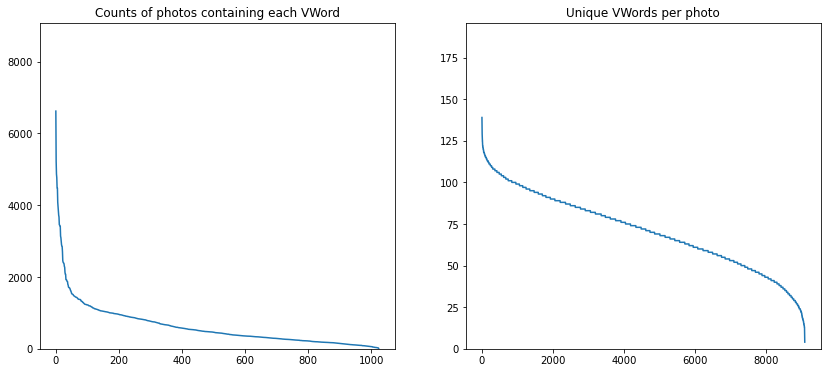

In [13]:
train(Path('../women-in-tshirts-256/'))